In [1]:
# Imports

from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.model_selection import KFold

In [2]:
# Variables to be used

EPOCH = 30
LEARNING_RATE = 0.001
OUTPUT_SIZE_PCA = 204
OUTPUT_SIZE = 4096

In [3]:
df_olivetti = fetch_olivetti_faces() 
print(df_olivetti.keys())

dict_keys(['data', 'images', 'target', 'DESCR'])


In [4]:
import matplotlib.pyplot as plt

# funtion for plotting faces
def plotting_fig(s):
    fig=plt.figure(figsize=(10,10))
    for i in range(100):
        ax=fig.add_subplot(10,10,i+1)
        ax.imshow(s[i], plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

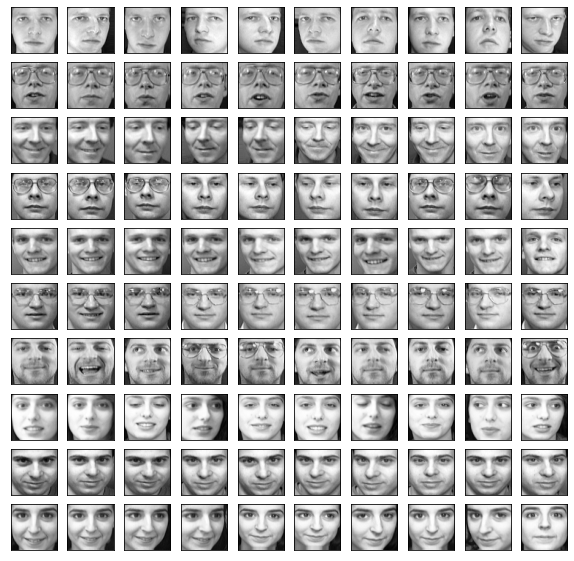

In [5]:
plotting_fig(df_olivetti.images)

In [6]:
# X and y data
olivetti_X, olivetti_y = df_olivetti.data, df_olivetti.target

print(olivetti_X.shape, olivetti_y.shape)

# Unique values of olivetti_y
print(np.unique(olivetti_y))

(400, 4096) (400,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [7]:
# Standardising the dataset
standardscalar = StandardScaler()
olivetti_X = standardscalar.fit_transform(olivetti_X)

In [8]:
# Normalizing the dataset
olivetti_X = normalize(olivetti_X)

In [9]:
# split into train, test sets
olivetti_X_train, olivetti_X_test, olivetti_y_train, olivetti_y_test = train_test_split(olivetti_X, olivetti_y, test_size=0.30, random_state=83, stratify=olivetti_y)

print(olivetti_X_train.shape, olivetti_X_test.shape, olivetti_y_train.shape, olivetti_y_test.shape)

(280, 4096) (120, 4096) (280,) (120,)


In [10]:
# split into test, validation sets
olivetti_X_test, olivetti_X_val, olivetti_y_test, olivetti_y_val = train_test_split(olivetti_X_test, olivetti_y_test, test_size=0.5, random_state=83, stratify=olivetti_y_test)


In [11]:
# Original Shape of Training data.
np.shape(olivetti_X_train)

(280, 4096)

In [12]:
# Using PCA to preserver 99% of the variance

pca = PCA(0.99)
olivetti_X_train_reduced = pca.fit_transform(olivetti_X_train)
olivetti_X_test_reduced = pca.transform(olivetti_X_test)
olivetti_X_val_reduced = pca.transform(olivetti_X_val)

print(olivetti_X_train_reduced.shape)
print(olivetti_X_test_reduced.shape)
print(olivetti_X_val_reduced.shape)

(280, 204)
(60, 204)
(60, 204)


In [13]:
# Define 'Autoencoder' class

from tensorflow.keras.models import Model

class Autoencoder(Model):
  def __init__(self, output_size, hidden_inputs=3, latent_d=3):
    super(Autoencoder, self).__init__()
    self.latent_d = latent_d

    self.encoder = tf.keras.Sequential([
      layers.Dense(hidden_inputs, activation='relu'),
      layers.Dense(latent_d, activation='relu')
    ])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(hidden_inputs, activation='relu'),     
      layers.Dense(output_size, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [14]:
# Using k-fold cross validation

# Concatenate X train and val pca reduced data
X_pca = np.concatenate((olivetti_X_train_reduced, olivetti_X_val_reduced))

In [15]:
def check(hidden_ips, latent_dimen, epoch = EPOCH, lr_rate = LEARNING_RATE, X_kfold = X_pca, output_size = OUTPUT_SIZE_PCA):
    for train_index,val_index in KFold(2).split(X_kfold):
      for hidden_input in hidden_ips:
        for latent_dim in latent_dimen:
          print("Number of hidden inputs: = "+ str(hidden_input) + ", Latent Dimesion = "+ str(latent_dim))
        
          #Splitting data into train and val data
          train_x, val_x = X_kfold[train_index],X_kfold[val_index]
        
          #Create & process autoencoder()
          autoencoder = Autoencoder(output_size, hidden_input, latent_dim)
          autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate), loss=losses.MeanSquaredError())
          autoencoder.fit(train_x, train_x,
                          epochs=epoch,
                          shuffle=True,
                          validation_data=(val_x, val_x))
          
          # encoding and decoding original images
          if output_size == OUTPUT_SIZE_PCA:
            enc_imgs = autoencoder.encoder(olivetti_X_test_reduced).numpy()
          else:
            enc_imgs = autoencoder.encoder(olivetti_X_test).numpy()
          
          dec_imgs = autoencoder.decoder(enc_imgs).numpy()

            
         #Plotting the images for original and reconstructed
          n = 5
          plt.figure(figsize=(20, 4))
          for i in range(n):
            # display original images
            ax = plt.subplot(2, n, i + 1)
            if output_size == OUTPUT_SIZE_PCA:
              image_pca = pca.inverse_transform(olivetti_X_test_reduced[i])
            else:
              image_pca = olivetti_X_test[i]
            img = image_pca.reshape(64,64)
            plt.imshow(img)
            plt.title("Original Image")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction images
            ax = plt.subplot(2, n, i + 1 + n)
            if output_size == OUTPUT_SIZE_PCA:
              image_pca = pca.inverse_transform(dec_imgs[i])
            else:
              image_pca = dec_imgs[i]
            img = image_pca.reshape(64,64)
            plt.imshow(img)
            plt.title("\nReconstructed Image")
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
          plt.show()

Number of hidden inputs: = 240, Latent Dimesion = 160
Epoch 1/30
6/6 [==============================] - 0s 19ms/step - loss: 0.2511 - val_loss: 0.2412
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2284 - val_loss: 0.1951
Epoch 3/30
6/6 [==============================] - 0s 11ms/step - loss: 0.1593 - val_loss: 0.0908
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0507 - val_loss: 0.0134
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 8/30
6/6 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - 

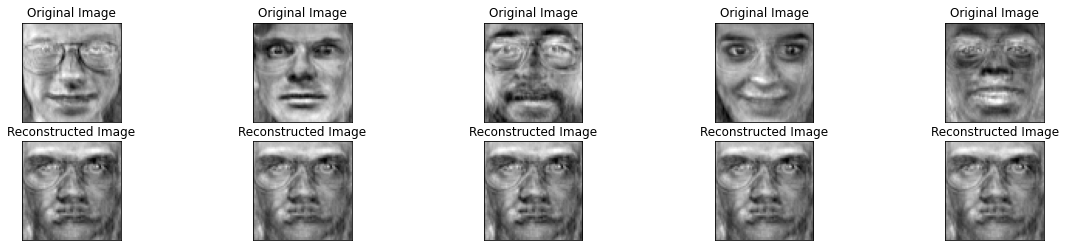

Number of hidden inputs: = 240, Latent Dimesion = 220
Epoch 1/30
6/6 [==============================] - 0s 15ms/step - loss: 0.2504 - val_loss: 0.2383
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2224 - val_loss: 0.1826
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1417 - val_loss: 0.0698
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0358 - val_loss: 0.0090
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

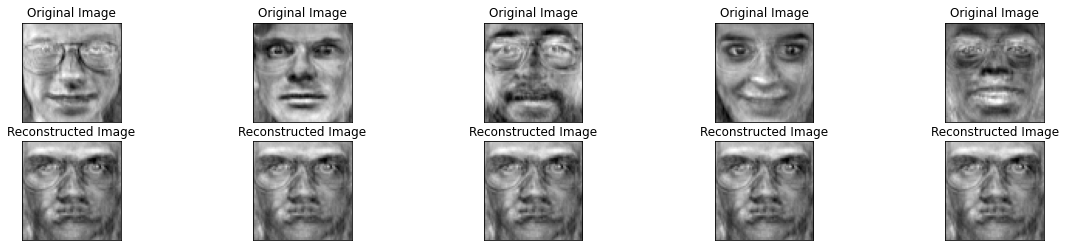

Number of hidden inputs: = 240, Latent Dimesion = 300
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2486 - val_loss: 0.2322
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2109 - val_loss: 0.1573
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1088 - val_loss: 0.0378
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0058
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

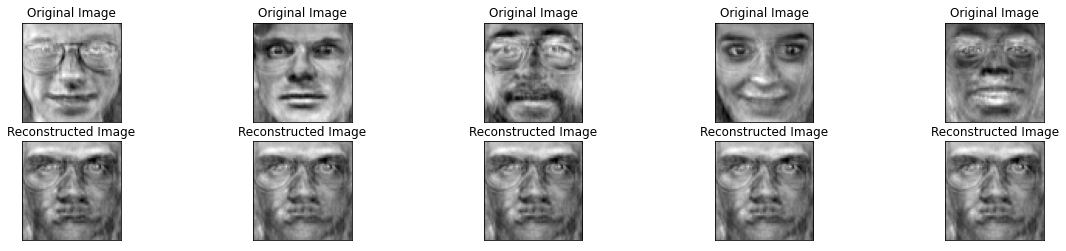

Number of hidden inputs: = 200, Latent Dimesion = 160
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2504 - val_loss: 0.2393
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2256 - val_loss: 0.1923
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1577 - val_loss: 0.0925
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0540 - val_loss: 0.0158
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0053
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

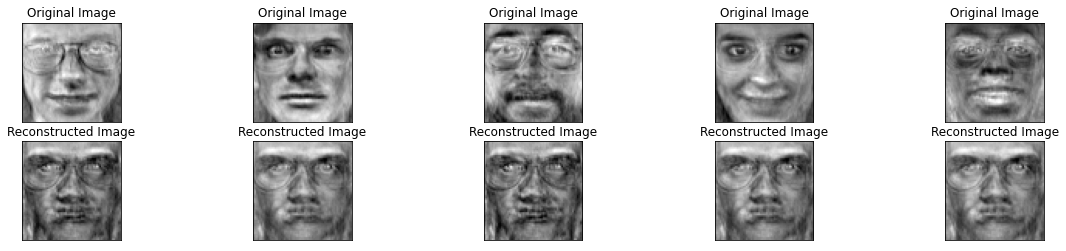

Number of hidden inputs: = 200, Latent Dimesion = 220
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2513 - val_loss: 0.2415
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2293 - val_loss: 0.1969
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1629 - val_loss: 0.0949
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0551 - val_loss: 0.0145
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0051
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

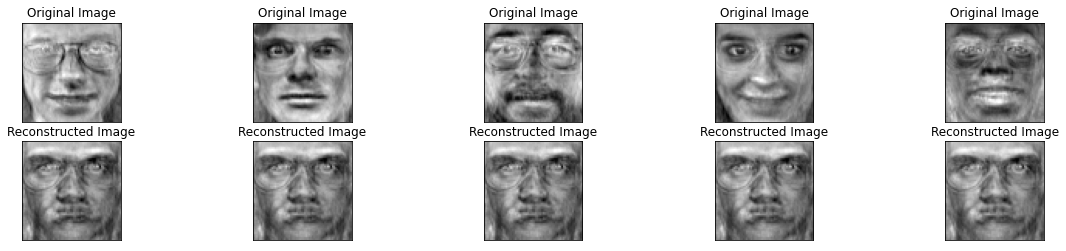

Number of hidden inputs: = 200, Latent Dimesion = 300
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2498 - val_loss: 0.2370
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2203 - val_loss: 0.1782
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1358 - val_loss: 0.0639
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0320 - val_loss: 0.0085
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

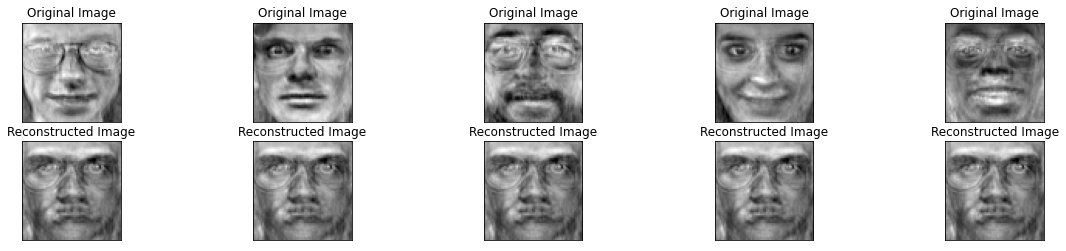

Number of hidden inputs: = 105, Latent Dimesion = 160
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2533 - val_loss: 0.2494
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2454 - val_loss: 0.2357
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2257 - val_loss: 0.2032
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1815 - val_loss: 0.1388
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1052 - val_loss: 0.0569
Epoch 6/30
6/6 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0136
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 9/30
6/6 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

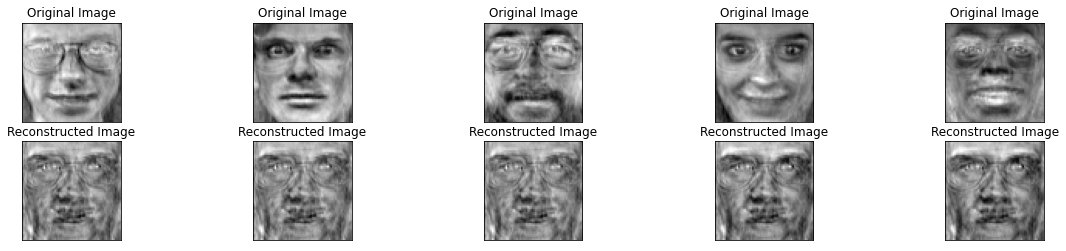

Number of hidden inputs: = 105, Latent Dimesion = 220
Epoch 1/30
6/6 [==============================] - 0s 42ms/step - loss: 0.2524 - val_loss: 0.2466
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2402 - val_loss: 0.2252
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2089 - val_loss: 0.1747
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1424 - val_loss: 0.0898
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0561 - val_loss: 0.0228
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0121 - val_loss: 0.0066
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

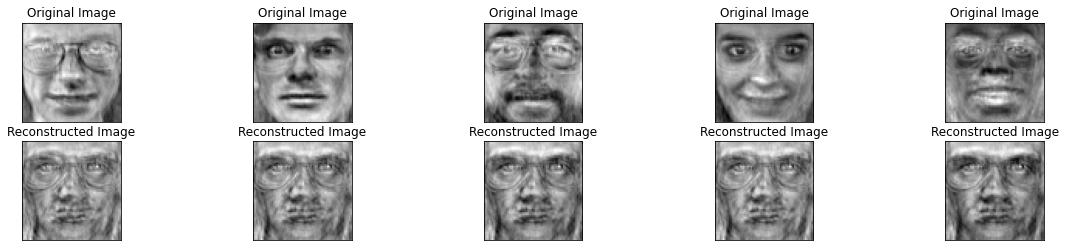

Number of hidden inputs: = 105, Latent Dimesion = 300
Epoch 1/30
6/6 [==============================] - 0s 13ms/step - loss: 0.2527 - val_loss: 0.2474
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2412 - val_loss: 0.2260
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2090 - val_loss: 0.1719
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1376 - val_loss: 0.0811
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0494 - val_loss: 0.0190
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0062
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

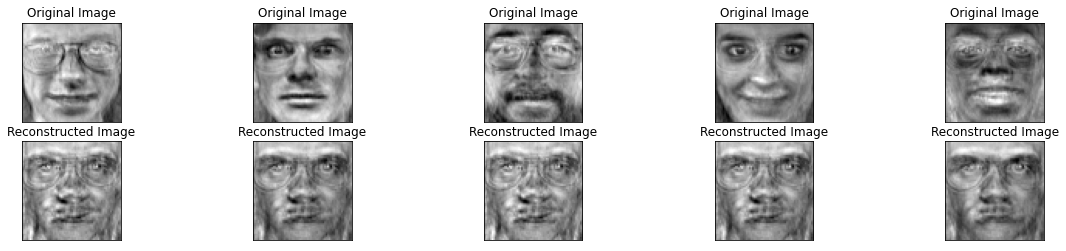

Number of hidden inputs: = 120, Latent Dimesion = 160
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2520 - val_loss: 0.2461
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2398 - val_loss: 0.2247
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2092 - val_loss: 0.1748
Epoch 4/30
6/6 [==============================] - 0s 3ms/step - loss: 0.1440 - val_loss: 0.0903
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0578 - val_loss: 0.0229
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0125 - val_loss: 0.0066
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 3ms/step - loss: 0.0047 - v

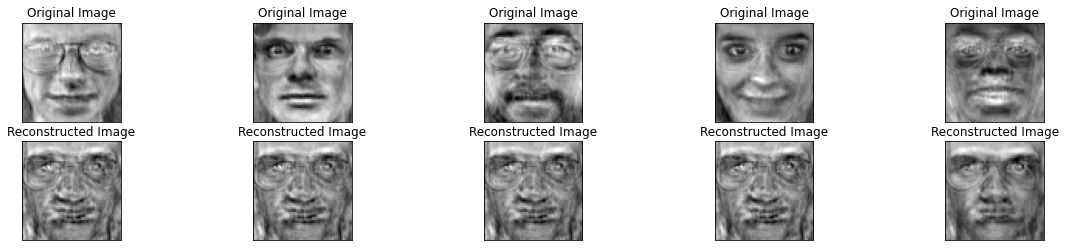

Number of hidden inputs: = 120, Latent Dimesion = 220
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2522 - val_loss: 0.2461
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2393 - val_loss: 0.2226
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2048 - val_loss: 0.1654
Epoch 4/30
6/6 [==============================] - 0s 3ms/step - loss: 0.1312 - val_loss: 0.0744
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0444 - val_loss: 0.0163
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

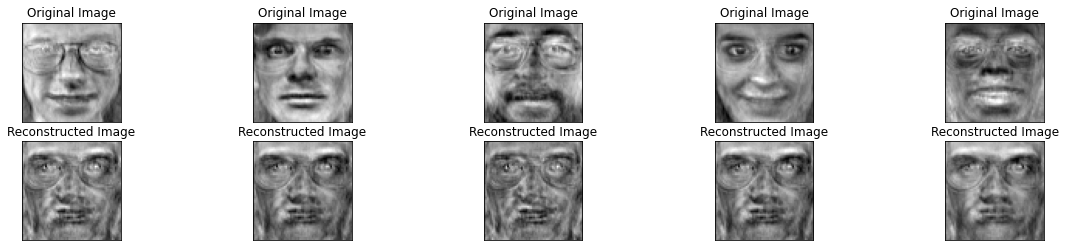

Number of hidden inputs: = 120, Latent Dimesion = 300
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2516 - val_loss: 0.2441
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2348 - val_loss: 0.2128
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1886 - val_loss: 0.1396
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0995 - val_loss: 0.0458
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0089
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - v

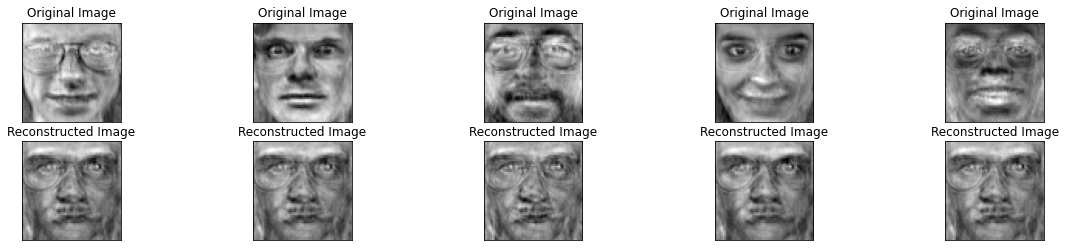

Number of hidden inputs: = 240, Latent Dimesion = 160
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2517 - val_loss: 0.2412
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2285 - val_loss: 0.1951
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1596 - val_loss: 0.0911
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0517 - val_loss: 0.0134
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0049
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

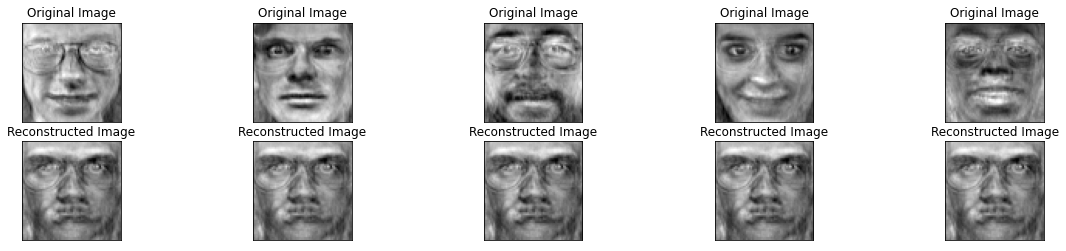

Number of hidden inputs: = 240, Latent Dimesion = 220
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2498 - val_loss: 0.2356
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2181 - val_loss: 0.1736
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1301 - val_loss: 0.0568
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0279 - val_loss: 0.0072
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

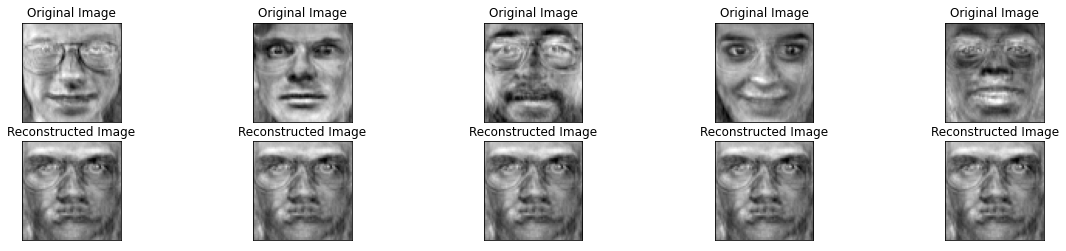

Number of hidden inputs: = 240, Latent Dimesion = 300
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2502 - val_loss: 0.2356
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2165 - val_loss: 0.1667
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1202 - val_loss: 0.0454
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.0060
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

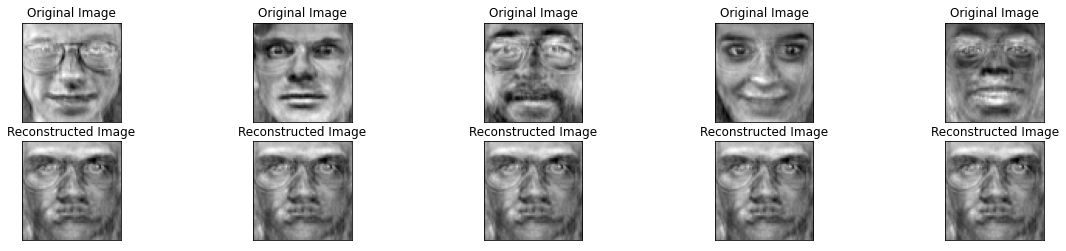

Number of hidden inputs: = 200, Latent Dimesion = 160
Epoch 1/30
6/6 [==============================] - 0s 13ms/step - loss: 0.2509 - val_loss: 0.2412
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2294 - val_loss: 0.2001
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1674 - val_loss: 0.1061
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0639 - val_loss: 0.0196
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0053
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

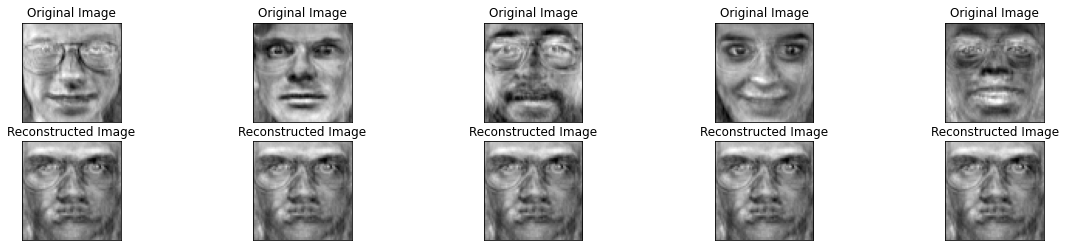

Number of hidden inputs: = 200, Latent Dimesion = 220
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2511 - val_loss: 0.2406
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2273 - val_loss: 0.1936
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1569 - val_loss: 0.0883
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0491 - val_loss: 0.0128
Epoch 5/30
6/6 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

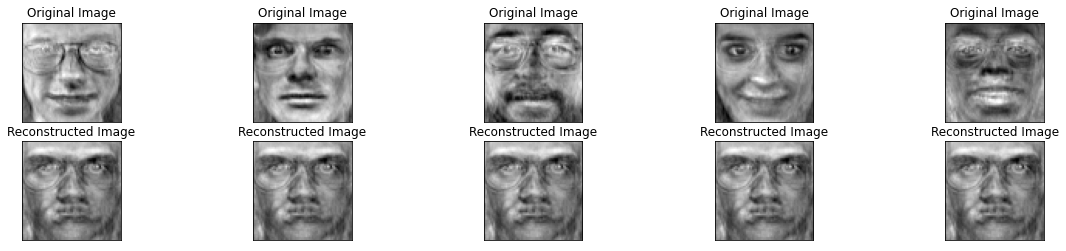

Number of hidden inputs: = 200, Latent Dimesion = 300
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2509 - val_loss: 0.2394
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2247 - val_loss: 0.1858
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1455 - val_loss: 0.0712
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0368 - val_loss: 0.0088
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

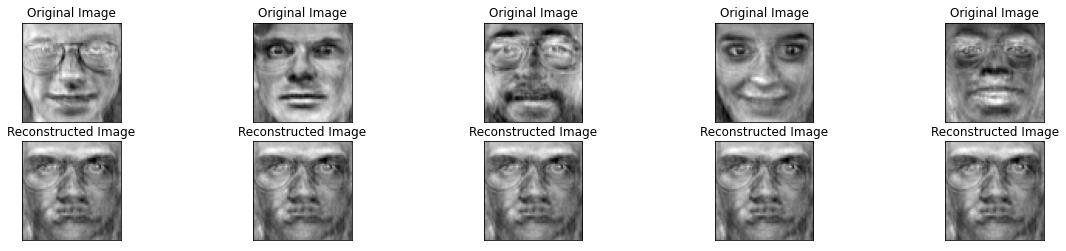

Number of hidden inputs: = 105, Latent Dimesion = 160
Epoch 1/30
6/6 [==============================] - 0s 38ms/step - loss: 0.2524 - val_loss: 0.2469
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2412 - val_loss: 0.2277
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2127 - val_loss: 0.1826
Epoch 4/30
6/6 [==============================] - 0s 3ms/step - loss: 0.1521 - val_loss: 0.1032
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0675 - val_loss: 0.0306
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0163 - val_loss: 0.0079
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 8/30
6/6 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

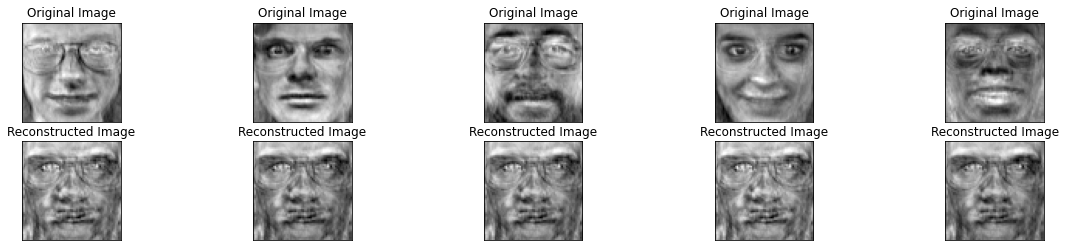

Number of hidden inputs: = 105, Latent Dimesion = 220
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2524 - val_loss: 0.2461
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2398 - val_loss: 0.2245
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2086 - val_loss: 0.1755
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1447 - val_loss: 0.0945
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0618 - val_loss: 0.0274
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0076
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

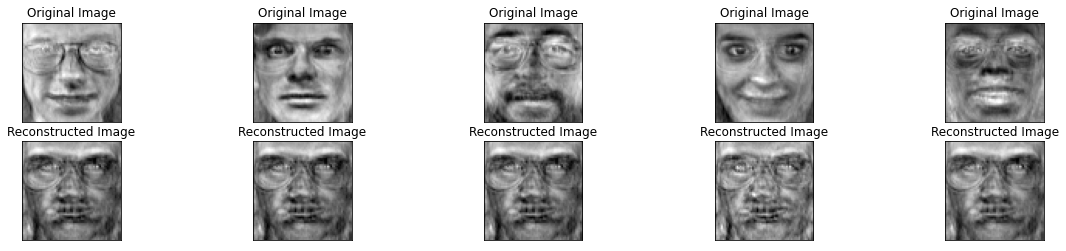

Number of hidden inputs: = 105, Latent Dimesion = 300
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2522 - val_loss: 0.2456
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2386 - val_loss: 0.2212
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2020 - val_loss: 0.1626
Epoch 4/30
6/6 [==============================] - 0s 3ms/step - loss: 0.1265 - val_loss: 0.0714
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0416 - val_loss: 0.0151
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

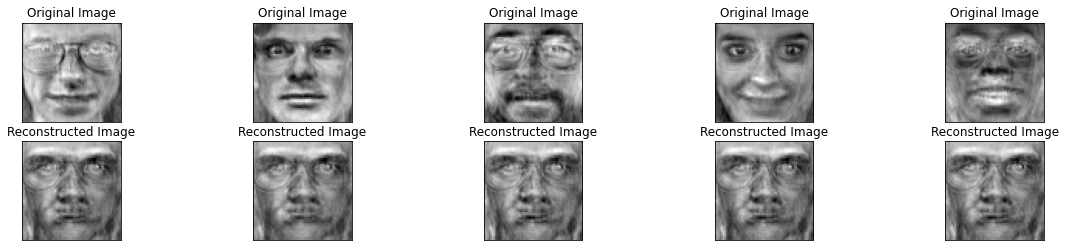

Number of hidden inputs: = 120, Latent Dimesion = 160
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2518 - val_loss: 0.2449
Epoch 2/30
6/6 [==============================] - 0s 3ms/step - loss: 0.2373 - val_loss: 0.2196
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2009 - val_loss: 0.1638
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1303 - val_loss: 0.0784
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0483 - val_loss: 0.0192
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0062
Epoch 7/30
6/6 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

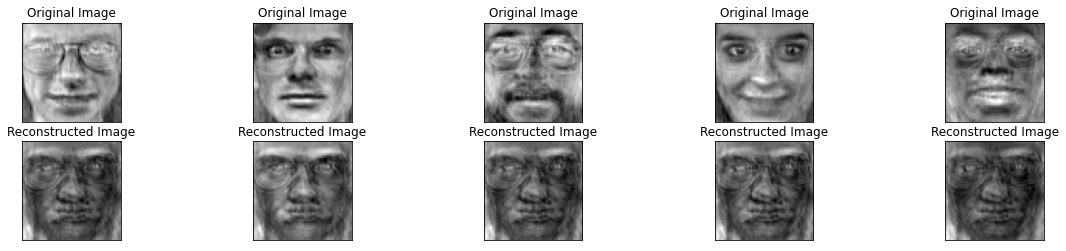

Number of hidden inputs: = 120, Latent Dimesion = 220
Epoch 1/30
6/6 [==============================] - 0s 13ms/step - loss: 0.2522 - val_loss: 0.2452
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2380 - val_loss: 0.2198
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2007 - val_loss: 0.1595
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1238 - val_loss: 0.0682
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0397 - val_loss: 0.0143
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 0.0054
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

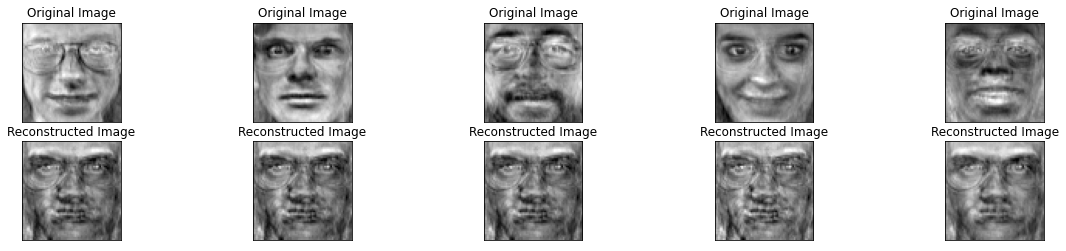

Number of hidden inputs: = 120, Latent Dimesion = 300
Epoch 1/30
6/6 [==============================] - 0s 14ms/step - loss: 0.2527 - val_loss: 0.2462
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2390 - val_loss: 0.2215
Epoch 3/30
6/6 [==============================] - 0s 4ms/step - loss: 0.2019 - val_loss: 0.1609
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 0.1242 - val_loss: 0.0685
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0400 - val_loss: 0.0148
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - v

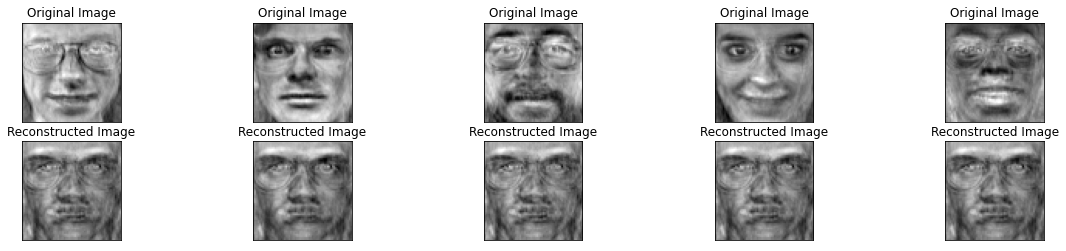

In [16]:
check([240, 200, 105, 120],[160, 220, 300], epoch = EPOCH, lr_rate = LEARNING_RATE)